In [64]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [65]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
}


url = 'https://en.wikipedia.org/wiki/List_of_Spotify_streaming_records'
response = requests.get(url, headers=headers)
html_content = response.text
print(f"Status Code: {response.status_code}")
print(f"HTML Length: {len(html_content)} characters")


Status Code: 200
HTML Length: 688637 characters


In [66]:
soup = BeautifulSoup(html_content, 'html.parser')
table = soup.find('table', class_='wikitable sortable plainrowheaders')

header_row = table.find('tr')
headers = [th.text.strip() for th in header_row.find_all('th')]

rows = []
for tr in table.find_all('tr')[1:]:
    all_cells = [td.text.strip() for td in tr.find_all(['th', 'td'])]
    if all_cells:
        rows.append(all_cells)

print(f"Total rows: {len(rows)}")
print(f"Headers: {headers}")
print(f"First row: {rows[0]}")
print(f"First row length: {len(rows[0])}")

Total rows: 101
Headers: ['Rank', 'Song', 'Artist(s)', 'Streams(billions)', 'Release date', 'Ref.']
First row: ['1', '"Blinding Lights"', 'The Weeknd', '5.258', '29 November 2019', '[1]']
First row length: 6


In [67]:
cleaned_rows = []

for row in rows:
    if len(row) == 6:
        cleaned_row = []

        rank = row[0].strip()
        cleaned_row.append(rank)

        song = row[1].strip().replace('"', '')
        cleaned_row.append(song)

        artist = row[2].strip()
        cleaned_row.append(artist)

        streams = row[3].strip().replace(',', '')
        cleaned_row.append(streams)

        release_date = row[4].strip()
        cleaned_row.append(release_date)

        reference = row[5].strip().replace('[', '').replace(']', '')
        cleaned_row.append(reference)

        cleaned_rows.append(cleaned_row)

print(f"Original rows: {len(rows)}")
print(f"Cleaned rows: {len(cleaned_rows)}")
print(f"First cleaned row: {cleaned_rows[0]}")
print(f"Last cleaned row: {cleaned_rows[-1]}")

Original rows: 101
Cleaned rows: 100
First cleaned row: ['1', 'Blinding Lights', 'The Weeknd', '5.258', '29 November 2019', '1']
Last cleaned row: ['100', 'All I Want For Christmas Is You', 'Mariah Carey', '2.506', '28 October 1994', '']


In [68]:
conn = sqlite3.connect('spotify_streaming_records.db')
cursor = conn.cursor()

cursor.execute('DROP TABLE IF EXISTS streaming_records')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS streaming_records (
    rank INTEGER,
    song TEXT,
    artist TEXT,
    stream_billions REAL,
    release_date TEXT,
    reference TEXT
    )
''')

for row in cleaned_rows:
    if len(row) == 6:
        cursor.execute('''
            INSERT INTO streaming_records
            (rank, song, artist, stream_billions, release_date, reference)
            VALUES (?, ?, ?, ?, ?, ?)
        ''', row)

conn.commit()

cursor.execute('SELECT COUNT(*) FROM streaming_records')
count = cursor.fetchone()[0]
print(f"Total records inserted: {count}")

cursor.execute('SELECT * FROM streaming_records LIMIT 5')
for record in cursor.fetchall():
    print(record)

conn.close()

Total records inserted: 100
(1, 'Blinding Lights', 'The Weeknd', 5.258, '29 November 2019', '1')
(2, 'Shape of You', 'Ed Sheeran', 4.75, '6 January 2017', '2')
(3, 'Sweater Weather', 'The Neighbourhood', 4.351, '3 December 2012', '3')
(4, 'Starboy', 'The Weeknd and Daft Punk', 4.34, '21 September 2016', '4')
(5, 'As It Was', 'Harry Styles', 4.226, '1 April 2022', '5')


In [69]:
conn = sqlite3.connect('spotify_streaming_records.db')
df = pd.read_sql_query("SELECT * FROM streaming_records", conn)
conn.close

print(df.head())
print(f"\nDataframe shape: {df.shape}")

   rank             song                    artist  stream_billions  \
0     1  Blinding Lights                The Weeknd            5.258   
1     2     Shape of You                Ed Sheeran            4.750   
2     3  Sweater Weather         The Neighbourhood            4.351   
3     4          Starboy  The Weeknd and Daft Punk            4.340   
4     5        As It Was              Harry Styles            4.226   

        release_date reference  
0   29 November 2019         1  
1     6 January 2017         2  
2    3 December 2012         3  
3  21 September 2016         4  
4       1 April 2022         5  

Dataframe shape: (100, 6)


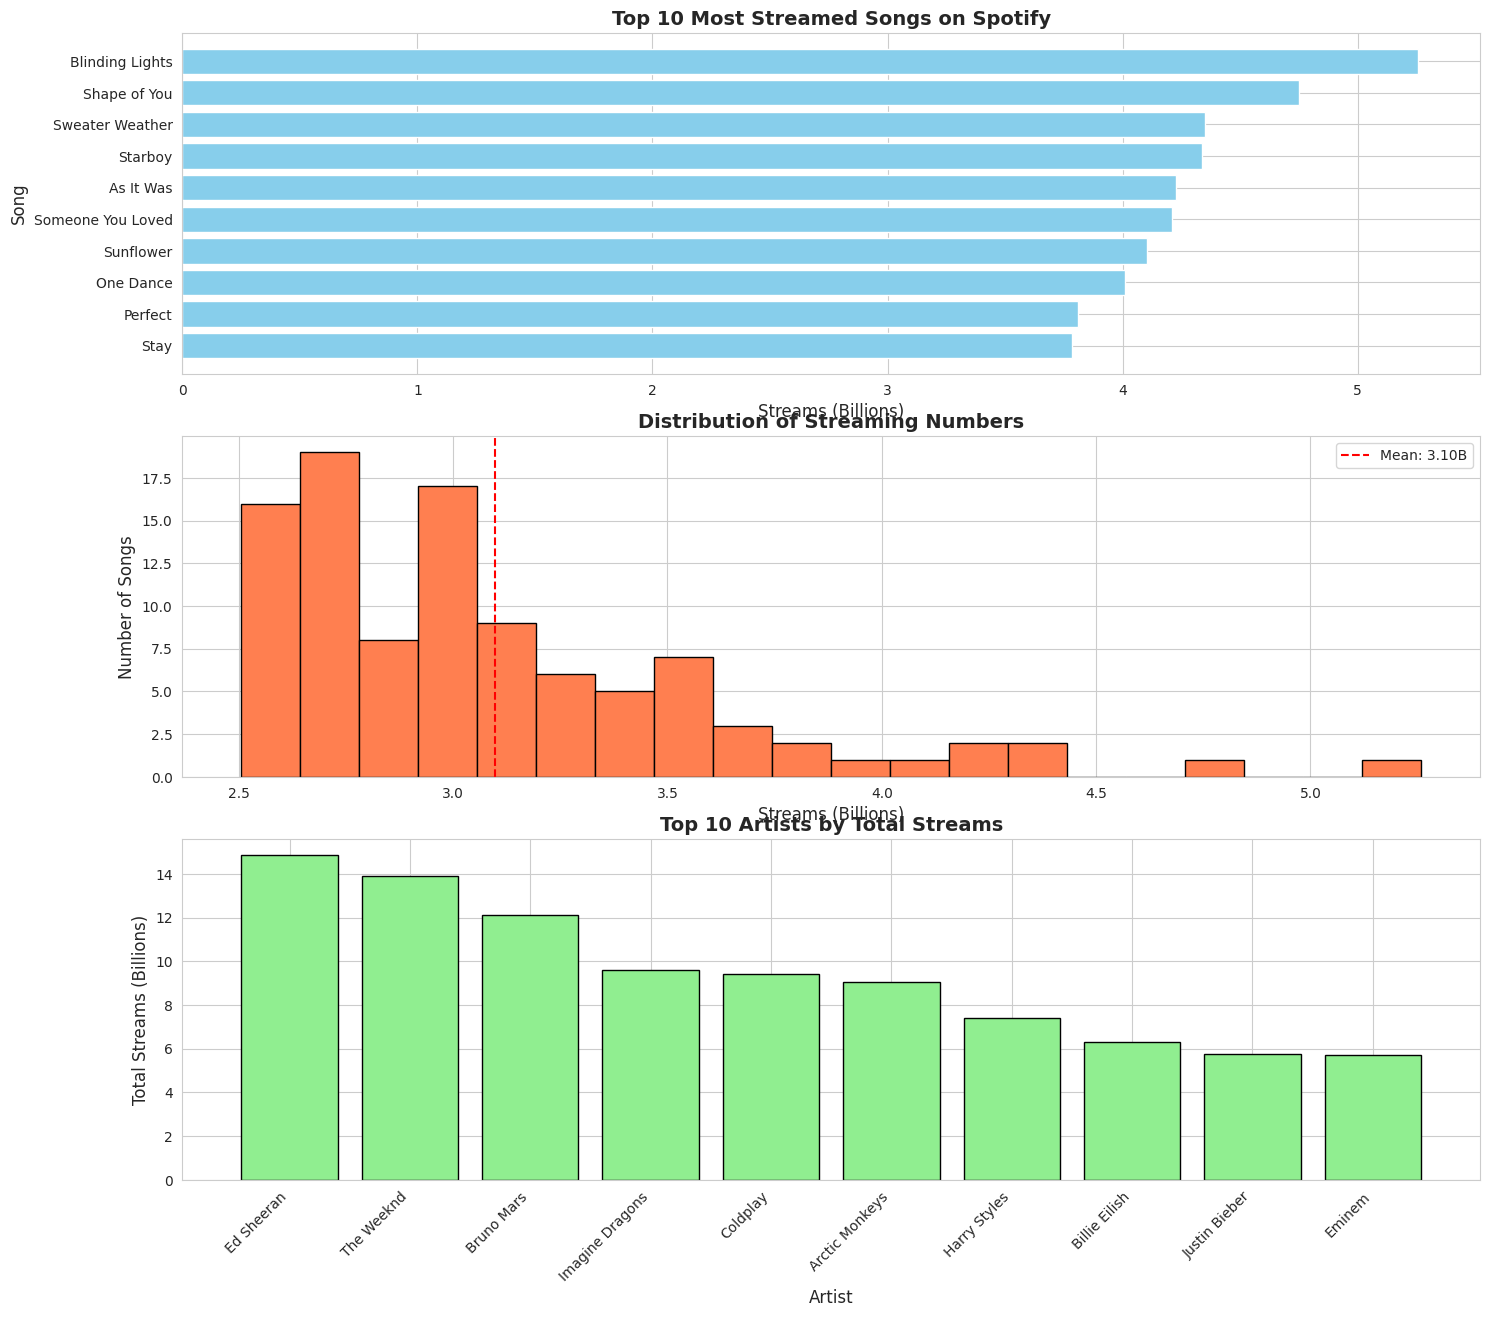

In [70]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
top_10 = df.head(10)
plt.barh(top_10['song'], top_10['stream_billions'], color='skyblue')
plt.xlabel('Streams (Billions)', fontsize=12)
plt.ylabel('Song', fontsize=12)
plt.title('Top 10 Most Streamed Songs on Spotify', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.subplot(3, 1, 2)
plt.hist(df['stream_billions'], bins=20, color='coral', edgecolor='black')
plt.xlabel('Streams (Billions)', fontsize=12)
plt.ylabel('Number of Songs', fontsize=12)
plt.title('Distribution of Streaming Numbers', fontsize=14, fontweight='bold')
plt.axvline(df['stream_billions'].mean(), color='red', linestyle='--', label=f'Mean: {df["stream_billions"].mean():.2f}B')
plt.legend()

plt.subplot(3, 1, 3)
artist_streams = df.groupby('artist')['stream_billions'].sum().sort_values(ascending=False).head(10)
plt.bar(range(len(artist_streams)), artist_streams.values, color='lightgreen', edgecolor='black')
plt.xticks(range(len(artist_streams)), artist_streams.index, rotation=45, ha='right')
plt.xlabel('Artist', fontsize=12)
plt.ylabel('Total Streams (Billions)', fontsize=12)
plt.title('Top 10 Artists by Total Streams', fontsize=14, fontweight='bold')

plt.show()